# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [20]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [9]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [10]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    # number of subprocesses to use for data loading
    num_workers = 0
    ## data argumentation might possible here
    transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    #transforms.CenterCrop(image_size),
    #transforms.RandomResizedCrop(image_size), 
    #transforms.RandomHorizontalFlip(), # randomly flip and rotate
    #transforms.RandomAffine([-10,10], translate = (0.2, 0.2), shear = 10),
    #transforms.RandomRotation(10),
    #normalize,
    transforms.ToTensor()
    ])
    
    data_transfer = datasets.ImageFolder(data_dir, transform=transform)
    loaders_scratch = torch.utils.data.DataLoader(data_transfer, batch_size=batch_size,
                                            shuffle=True,
                                            num_workers=num_workers, 
                                           )   
    
    return loaders_scratch


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [11]:
# Define function hyperparameters
# batch_size = 128 ## batch size
batch_size = 64 ## batch size
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

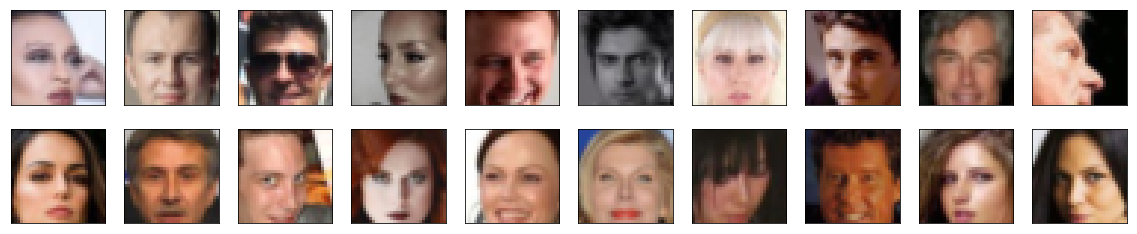

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [12]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [17]:
'''Convolutional Helper Function'''
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

###### Discriminator 1

In [21]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 32, depth 3 - 64
        self.conv_2 = conv(conv_dim, conv_dim*2, 4) # 16, 128
        self.conv_3 = conv(conv_dim*2, conv_dim*4, 4) # 8, 256
        self.conv_4 = conv(conv_dim*4, conv_dim*8, 4) # 4, 512
        ## classification _layer
        self.conv_5 = conv(conv_dim*8, 1, kernel_size=4, stride=1, batch_norm = False)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv_1(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv_2(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv_3(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv_4(x), 0.2)
        #print(x.shape)
        ## classification _layer
        x = self.conv_5(x)
        #print(x.shape)
        x = x.view(-1, 1)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


###### Discriminator 2

In [22]:
### second discriminator
''' k =5, s = 2, p = 2'''
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        ''' k =5, s = 2, p = 2'''
        # complete init function
        self.conv_1 = conv(3, conv_dim, 5, stride=2, padding=2, batch_norm=False) # x, y = 32, depth 3 - 64
        self.conv_2 = conv(conv_dim, conv_dim*2, 5, stride=2, padding=2) # 16, 128
        self.conv_3 = conv(conv_dim*2, conv_dim*4, 5, stride=2, padding=2) # 8, 256
        self.conv_4 = conv(conv_dim*4, conv_dim*8, 5, stride=2, padding=2) # 4, 512
        ## classification _layer
        self.conv_5 = conv(conv_dim*8, 1, kernel_size=5, stride=2, padding=2, batch_norm = False)


    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv_1(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv_2(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv_3(x), 0.2)
        #print(x.shape)
        x = F.leaky_relu(self.conv_4(x), 0.2)
        #print(x.shape)
        ## classification _layer
        x = self.conv_5(x)
        #print(x.shape)
        x = x.view(-1, 1)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [23]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True, output_padding=0):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, output_padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

###### Generator 1

In [15]:
class Generator(nn.Module):
    ''' k =4, s = 2, p = 1'''
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*16*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*16, conv_dim*8, 4, stride=2)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4, stride=2)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4, stride=2)
        self.t_conv4 = deconv(conv_dim*2, 3, 4, stride=2, batch_norm=False) # should output 32 x 32 x 3
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*16, 2, 2) # (batch_size, depth, 2, 2)
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))

        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


###### Generator 2

In [24]:
class Generator(nn.Module):
    ''' k =5, s = 2, p = 2'''
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*16*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*16, conv_dim*8, 5, stride=2, padding=2, output_padding=1)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 5, stride=2, padding=2, output_padding=1)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 5, stride=2, padding=2, output_padding=1)
        self.t_conv4 = deconv(conv_dim*2, 3, 5, stride=2, padding=2, output_padding=1, batch_norm=False) # should output 32 x 32 x 3
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*16, 2, 2) # (batch_size, depth, 2, 2)

        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [25]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    # Apply initial weights to convolutional and linear layers
    classname = m.__class__.__name__
    #if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:

        y = 0.02
        m.weight.data.normal_(0, y)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.fill_(0.0) # bais term set to 0
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [27]:
# Define model hyperparams
''' generator is slightly larger than discriminator'''
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  )
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(1024, 512,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [29]:
'''Least square error loss'''
def real_mse_loss(D_out, smooth=False):
    # how close is the produced output from being "real"?
    batch_size = D_out.size(0)
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    #return torch.mean((D_out - labels)**2)
    return torch.mean((D_out.squeeze()-labels)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "false"?
        
    return torch.mean(D_out**2)

In [30]:
''' Binary cross entropy loss'''
def real_loss(D_out, smooth= False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

Use SGD for D, ADAM for G. ADAM optimizer are examined to be efficient for 
DCGAN by few papers. 

In [31]:
import torch.optim as optim

# hyperparams for Adam optimizers
# 0.001 or 0.0002
lr= 0.0002
## The beta1 as 0.5 seems a bit high. 
## It's noticed by keeping the decay 
## rate lower the network performs better.
beta1= 0.5 ## From original DCGAN paper
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [32]:
## The adaptive learning rate from github (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git)
niter = 100 # default # of iter at starting learning rate
niter_decay = 100 # of iter to linearly decay learning rate to zero (every niter_decay epochs decayed by gama)
# niter + niter_decay = number of epochs
lr_decay_iters = 20 # default=50, multiply by a gamma every lr_decay_iters iterations, lr decay every lr_decay_iters epochs
lr_policy = 'step' # 'learning rate policy: lambda|step|plateau|cosine'
epoch_count = 1 # start of epoch, 

In [33]:
from torch.optim import lr_scheduler
def get_scheduler(optimizer):
    if lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + epoch_count - niter) / float(niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_iters, gamma=0.5)
    elif lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=niter, eta_min=0)
    else:
        return NotImplementedError('learning rate strategies [%s] is not available', lr_policy)
    return scheduler

In [34]:
optimizers = []
optimizers.append(g_optimizer)
optimizers.append(d_optimizer)
schedulers = [get_scheduler(optimizer) for optimizer in optimizers]

In [35]:
## test the schedulers contains how many optimizers
## should have number of scheduler equal to number of optimizers
schedulers

In [36]:
# update lr (called in every epoch)
def update_learning_rate():
    for scheduler in schedulers:
        scheduler.step() ## update the learning rate
    lr = optimizers[0].param_groups[0]['lr']
    print('Initial learning rate = %.7f' % lr) 
update_learning_rate()

Initial learning rate = 0.0002000


---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [38]:
def train(D, G, n_epochs, print_every=50, loss_type = 'bce'):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       param, loss_type: define the loss function type 
       return: D and G losses'''
    
    ## save path of model in every epoch 
    save_path_g = 'G.pt'
    save_path_d = 'D.pt'
    '''change save sample images every 20 epochs'''
    ## save the images in every 'save_every_e' epoch
    save_every_e=20
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    ## can be normal distribution N(0, 1)
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            
            if(loss_type == 'bce'):
                real_loss_function = real_loss
                fake_loss_function = fake_loss
            elif(loss_type == 'lse'):
                real_loss_function = real_mse_loss
                fake_loss_function = fake_mse_loss

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if(train_on_gpu):
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()
            # 1. Train the discriminator on real and fake images
            
            D_real = D(real_images)
            d_real_loss = real_loss_function(D_real, smooth=True)
            # d_real_loss = real_mse_loss(D_real)
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss_function(D_fake)
            #d_fake_loss = fake_mse_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss_function(D_fake, smooth=True) # use real loss to flip labels
            # g_loss = real_mse_loss(D_fake)
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

            
        '''Adaptive learning rate'''
        '''test'''
        #schedulers = [get_scheduler(optimizer) for optimizer in optimizers]
        update_learning_rate()
        
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # of the generate and save sample, fake images
        G.eval() # for generating samples
        if train_on_gpu:
            fixed_z = fixed_z.cuda()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode 
        
        if (epoch+1) % save_every_e == 0:
            # save generator model and discriminator model for future uses
            print('Save model during training in epoch [{:5d}]'.format(epoch+1))
            torch.save(G.state_dict(), save_path_g)
            torch.save(D.state_dict(), save_path_d)
            # Save training generator samples in each epochs
            with open('train_samples_epoch_{:5d}.pkl'.format(epoch+1), 'wb') as f:
                pkl.dump(samples, f)
    
    
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
### keep the cell running longer than 30 mins with GPU 
import workspace_utils
from workspace_utils import active_session

with active_session():
    
    # set number of epochs 
    n_epochs = 45


    """
    DON'T MODIFY ANYTHING IN THIS CELL
    """
    # call training function 
    losses = train(D, G, n_epochs=n_epochs, loss_type = 'lse')
    ## plot the losses 
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()

Epoch [    1/   45] | d_loss: 0.1684 | g_loss: 0.4000
Epoch [    1/   45] | d_loss: 0.2667 | g_loss: 0.6306
Epoch [    1/   45] | d_loss: 0.3563 | g_loss: 0.4981
Epoch [    1/   45] | d_loss: 0.3983 | g_loss: 0.3355
Epoch [    1/   45] | d_loss: 0.2343 | g_loss: 0.6872
Epoch [    1/   45] | d_loss: 0.2011 | g_loss: 0.6492
Epoch [    1/   45] | d_loss: 0.3450 | g_loss: 0.6836
Epoch [    1/   45] | d_loss: 0.3232 | g_loss: 0.8329
Epoch [    1/   45] | d_loss: 0.2459 | g_loss: 0.8016
Epoch [    1/   45] | d_loss: 0.2617 | g_loss: 0.5677
Epoch [    1/   45] | d_loss: 0.3499 | g_loss: 1.2084
Epoch [    1/   45] | d_loss: 0.3782 | g_loss: 0.8041
Epoch [    1/   45] | d_loss: 0.2277 | g_loss: 0.4797
Epoch [    1/   45] | d_loss: 0.3313 | g_loss: 0.6337
Epoch [    1/   45] | d_loss: 0.1912 | g_loss: 0.6481
Epoch [    1/   45] | d_loss: 0.4723 | g_loss: 0.2842
Epoch [    1/   45] | d_loss: 0.3378 | g_loss: 0.3415
Epoch [    1/   45] | d_loss: 0.2125 | g_loss: 0.8799
Epoch [    1/   45] | d_loss

The training process crahsed due to memory problem, we have to manually insert all the losses.

In [1]:
import numpy as np
losses = []

In [2]:
losses.append(( 0.1684, 0.4000))
losses.append(( 0.2667, 0.6306))
losses.append(( 0.3563, 0.4981))
losses.append(( 0.3983, 0.3355))
losses.append(( 0.2343, 0.6872))
losses.append(( 0.2011, 0.6492))
losses.append(( 0.3450, 0.6836))
losses.append(( 0.3232, 0.8329))
losses.append(( 0.2459, 0.8016))
losses.append(( 0.2617, 0.5677))
losses.append(( 0.3499, 1.2084))
losses.append(( 0.3782, 0.8041))
losses.append(( 0.2277, 0.4797))
losses.append(( 0.3313, 0.6337))
losses.append(( 0.1912, 0.6481))
losses.append(( 0.4723, 0.2842))
losses.append(( 0.3378, 0.3415))
losses.append(( 0.2125, 0.8799))
losses.append(( 0.3261, 0.3617))
losses.append(( 0.3419, 0.9380))
losses.append(( 0.2368, 0.8694))
losses.append(( 0.2214, 0.4157))
losses.append(( 0.3531, 0.2911))
losses.append(( 0.2872, 0.7010))
losses.append(( 0.2594, 0.6048))
losses.append(( 0.3626, 0.4185))
losses.append(( 0.3543, 0.6271))
losses.append(( 0.3115, 0.7222))
losses.append(( 0.2619, 0.3865))

losses.append(( 0.3257, 0.4793))
losses.append(( 0.3024, 0.6136))
losses.append(( 0.3930, 0.2900))
losses.append(( 0.3596, 0.5568))
losses.append(( 0.2186, 0.4279))
losses.append(( 0.2768, 0.5159))
losses.append(( 0.3213, 0.3575))
losses.append(( 0.2779, 0.5247))
losses.append(( 0.2950, 0.3092))
losses.append(( 0.3370, 0.4654))
losses.append(( 0.3222, 0.8134))
losses.append(( 0.2526, 0.5046))
losses.append(( 0.2879, 0.7823))
losses.append(( 0.3414, 0.6207))
losses.append(( 0.3114, 0.5982))
losses.append(( 0.3001, 0.4800))
losses.append(( 0.3524, 0.7244))
losses.append(( 0.2730, 0.4753))
losses.append(( 0.2567, 0.4926))
losses.append(( 0.2939, 0.7322))
losses.append(( 0.2689, 0.4502))
losses.append(( 0.3137, 0.3074))
losses.append(( 0.2323, 0.4104))
losses.append(( 0.3957, 0.5936))
losses.append(( 0.2687, 0.5712))
losses.append(( 0.3310, 0.5655))
losses.append(( 0.3281, 0.3668))
losses.append(( 0.4123, 0.7130))
losses.append(( 0.3280, 0.5277))
 #
losses.append(( 0.3897, 0.9139))
losses.append(( 0.3333, 0.3754))
losses.append(( 0.2712, 0.6042))
losses.append(( 0.2180, 0.6136))
losses.append(( 0.2364, 0.6536))
losses.append(( 0.2403, 0.7271))
losses.append(( 0.4481, 0.4650))
losses.append(( 0.3781, 0.3706))
losses.append(( 0.2476, 0.3923))
losses.append(( 0.3403, 0.2088))
losses.append(( 0.3216, 0.7058))
losses.append(( 0.2842, 0.6877))
losses.append(( 0.3240, 0.4424))
losses.append(( 0.2653, 0.5425))
losses.append(( 0.2980, 0.4330))
losses.append(( 0.2983, 0.3764))
losses.append(( 0.2730, 0.5021))
losses.append(( 0.3483, 0.3506))
losses.append(( 0.3629, 0.2962))
losses.append(( 0.3470, 0.4104))
losses.append(( 0.2791, 0.4772))
losses.append(( 0.3136, 0.5747))
losses.append(( 0.3475, 0.3776))
losses.append(( 0.2632, 0.4127))
losses.append(( 0.2553, 0.4592))
losses.append(( 0.2551, 0.5591))
losses.append(( 0.2916, 0.3415))
losses.append(( 0.2880, 0.4017))
losses.append(( 0.3766, 0.3156))
 #
losses.append((0.3995, 0.7953))
losses.append((0.2697, 0.3787))
losses.append((0.3521, 0.4902))
losses.append((0.2730, 0.3786))
losses.append((0.3641, 0.7963))
losses.append((0.3419, 0.2828))
losses.append((0.3514, 0.6800))
losses.append((0.3925, 0.3791))
losses.append((0.2694, 0.4345))
losses.append((0.3110, 0.4750))
losses.append((0.2981, 0.2544))
losses.append((0.2410, 0.3431))
losses.append((0.2555, 0.3857))
losses.append((0.2726, 0.4360))
losses.append((0.3199, 0.4711))
losses.append((0.2930, 0.3516))
losses.append((0.4018, 0.2787))
losses.append((0.2659, 0.8866))
losses.append((0.1962, 0.3191))
losses.append((0.3006, 0.2613))
losses.append((0.3470, 0.2837))
losses.append((0.3167, 0.4296))
losses.append((0.3389, 0.8543))
losses.append((0.2462, 0.2131))
losses.append((0.3385, 0.3706))
losses.append((0.3485, 0.5034))
losses.append((0.4243, 0.4356))
losses.append((0.2643, 0.4787))
losses.append((0.3795, 0.2161))
 #
losses.append((0.6828, 1.0439))
losses.append((0.3124, 0.3520))
losses.append((0.2836, 0.2294))
losses.append((0.2610, 0.4160))
losses.append((0.3069, 0.3474))
losses.append((0.3298, 0.6479))
losses.append((0.3947, 0.2711))
losses.append((0.2504, 0.4144))
losses.append((0.3131, 0.3856))
losses.append((0.3454, 0.4925))
losses.append((0.2736, 0.5985))
losses.append((0.3103, 0.7497))
losses.append((0.1816, 0.5458))
losses.append((0.2688, 0.5391))
losses.append((0.2812, 0.2245))
losses.append((0.5255, 0.7145))
losses.append((0.4778, 0.5813))
losses.append((0.2900, 0.5343))
losses.append((0.2995, 0.3717))
losses.append((0.2826, 0.3485))
losses.append((0.3807, 0.7167))
losses.append((0.2846, 0.3151))
losses.append((0.2014, 0.5741))
losses.append((0.2274, 0.3417))
losses.append((0.2263, 0.4003))
losses.append((0.3245, 0.6982))
losses.append((0.2262, 0.3801))
losses.append((0.2794, 0.3270))
losses.append((0.3469, 0.1673))
 #
losses.append((0.3532, 0.2991))
losses.append((0.3497, 0.3845))
losses.append((0.2326, 0.2778))
losses.append((0.3780, 0.4769))
losses.append((0.2197, 0.5535))
losses.append((0.3459, 0.4667))
losses.append((0.4162, 0.5134))
losses.append((0.2434, 0.4691))
losses.append((0.4324, 0.7584))
losses.append((0.1982, 0.5416))
losses.append((0.3115, 0.2896))
losses.append((0.3379, 0.2598))
losses.append((0.2657, 0.4819))
losses.append((0.3300, 0.9457))
losses.append((0.2297, 0.4292))
losses.append((0.3399, 0.3562))
losses.append((0.3876, 0.3230))
losses.append((0.3521, 0.2688))
losses.append((0.2598, 0.4617))
losses.append((0.1985, 0.2388))
losses.append((0.3526, 0.5418))
losses.append((0.2165, 0.4882))
losses.append((0.2737, 0.3076))
losses.append((0.2531, 0.5504))
losses.append((0.2399, 0.3750))
losses.append((0.3000, 0.4205))
losses.append((0.2491, 0.3733))
losses.append((0.4015, 0.5057))
losses.append((0.2902, 0.4930))
 #
losses.append((0.4525, 0.6309))
losses.append((0.2749, 0.1055))
losses.append((0.2572, 0.3318))
losses.append((0.2224, 0.4184))
losses.append((0.3528, 0.6659))
losses.append((0.3515, 0.2151))
losses.append((0.1755, 0.4930))
losses.append((0.3227, 0.6687))
losses.append((0.2741, 0.3736))
losses.append((0.2350, 0.3256))
losses.append((0.1663, 0.6036))
losses.append((0.2588, 0.6724))
losses.append((0.4218, 0.2800))
losses.append((0.2094, 0.5057))
losses.append((0.2478, 0.5288))
losses.append((0.4093, 0.4219))
losses.append((0.3505, 0.2905))
losses.append((0.2446, 0.4340))
losses.append((0.2506, 0.2523))
losses.append((0.1783, 0.2492))
losses.append((0.2760, 0.4470))
losses.append((0.3159, 0.2932))
losses.append((0.2088, 0.3703))
losses.append((0.3035, 0.4571))
losses.append((0.3173, 0.1746))
losses.append((0.3061, 0.6972))
losses.append((0.2627, 0.1962))
losses.append((0.3550, 0.2825))
losses.append((0.2810, 0.4379))
 #
losses.append((0.2761, 0.4381))
losses.append((0.2511, 0.5191))
losses.append((0.3047, 0.2924))
losses.append((0.5506, 0.6093))
losses.append((0.2582, 0.3689))
losses.append((0.2899, 0.3544))
losses.append((0.3145, 0.3758))
losses.append((0.3051, 0.3547))
losses.append((0.2521, 0.6791))
losses.append((0.2160, 0.5478))
losses.append((0.2178, 0.6592))
losses.append((0.3763, 0.2994))
losses.append((0.2704, 0.5105))
losses.append((0.3754, 0.3613))
losses.append((0.2394, 0.4029))
losses.append((0.3283, 0.2996))
losses.append((0.1939, 0.3768))
losses.append((0.3815, 0.6496))
losses.append((0.2751, 0.2073))
losses.append((0.3203, 0.2851))
losses.append((0.3346, 0.4727))
losses.append((0.2668, 0.6796))
losses.append((0.2541, 0.2203))
losses.append((0.1742, 0.6436))
losses.append((0.2082, 0.5469))
losses.append((0.1766, 0.4710))
losses.append((0.2895, 0.4474))
losses.append((0.1962, 0.5272))
losses.append((0.2583, 0.4616))
 #
losses.append((0.4239, 0.6061))
losses.append((0.2019, 0.5638))
losses.append((0.2395, 0.5757))
losses.append((0.2429, 0.3857))
losses.append((0.1506, 0.7553))
losses.append((0.2083, 0.2454))
losses.append((0.2144, 0.6386))
losses.append((0.2263, 0.4018))
losses.append((0.1890, 0.3814))
losses.append((0.2177, 0.2439))
losses.append((0.2590, 0.3905))
losses.append((0.2737, 0.7203))
losses.append((0.2502, 0.2321))
losses.append((0.3306, 0.4350))
losses.append((0.3306, 0.4197))
losses.append((0.2974, 0.3569))
losses.append((0.2002, 0.3992))
losses.append((0.2636, 0.3961))
losses.append((0.2706, 0.3222))
losses.append((0.1831, 0.6515))
losses.append((0.1831, 0.6927))
losses.append((0.2139, 0.4628))
losses.append((0.1632, 0.4396))
losses.append((0.3032, 0.3439))
losses.append((0.1686, 0.3683))
losses.append((0.2431, 0.4637))
losses.append((0.2506, 0.3960))
losses.append((0.1445, 0.4265))
losses.append((0.3134, 0.3678))
 #
losses.append((0.3564, 0.9424))
losses.append((0.2689, 0.4346))
losses.append((0.2258, 0.6433))
losses.append((0.3945, 0.8178))
losses.append((0.2297, 0.3804))
losses.append((0.2416, 0.3227))
losses.append((0.2247, 0.4359))
losses.append((0.2697, 0.7286))
losses.append((0.3142, 0.4963))
losses.append((0.2044, 0.3794))
losses.append((0.2524, 0.4201))
losses.append((0.2063, 0.2751))
losses.append((0.3614, 0.1034))
losses.append((0.2846, 0.6720))
losses.append((0.3123, 0.6271))
losses.append((0.2440, 0.5084))
losses.append((0.3325, 0.3719))
losses.append((0.1877, 0.2138))
losses.append((0.1565, 0.8443))
losses.append((0.2147, 0.6443))
losses.append((0.2348, 0.3780))
losses.append((0.2925, 0.5442))
losses.append((0.1632, 0.3934))
losses.append((0.1444, 0.6879))
losses.append((0.2432, 0.3203))
losses.append((0.1882, 0.5717))
losses.append((0.1813, 0.5673))
losses.append((0.2836, 0.2411))
losses.append((0.2718, 0.7314))
 #
losses.append((0.3087, 0.6819))
losses.append((0.2633, 0.3088))
losses.append((0.3369, 0.2232))
losses.append((0.1558, 0.4256))
losses.append((0.2483, 0.3323))
losses.append((0.1864, 0.6140))
losses.append((0.1279, 0.3422))
losses.append((0.1616, 0.4410))
losses.append((0.3182, 0.3689))
losses.append((0.2253, 0.4468))
losses.append((0.3780, 1.5359))
losses.append((0.2642, 0.4479))
losses.append((0.1814, 0.3156))
losses.append((0.4272, 0.2323))
losses.append((0.1608, 0.6651))
losses.append((0.4092, 0.5936))
losses.append((0.2430, 0.5188))
losses.append((0.2219, 0.7999))
losses.append((0.1844, 0.5786))
losses.append((0.1857, 0.4353))
losses.append((0.1223, 0.6983))
losses.append((0.1700, 0.5566))
losses.append((0.1471, 0.4121))
losses.append((0.1380, 0.8294))
losses.append((0.1325, 0.4144))
losses.append((0.1208, 0.4235))
losses.append((0.1186, 0.4928))
losses.append((0.1555, 0.6187))
losses.append((0.2307, 0.4508))
 #
losses.append((0.2630, 0.6670))
losses.append((0.2412, 0.5596))
losses.append((0.2409, 0.5730))
losses.append((0.3493, 0.3765))
losses.append((0.1357, 0.6983))
losses.append((0.1206, 0.9381))
losses.append((0.2524, 0.8090))
losses.append((0.2797, 0.3290))
losses.append((0.2892, 0.3793))
losses.append((0.3469, 0.9030))
losses.append((0.2105, 0.3753))
losses.append((0.1656, 0.6347))
losses.append((0.1570, 0.3093))
losses.append((0.1593, 0.3061))
losses.append((0.3094, 0.6896))
losses.append((0.1123, 0.5450))
losses.append((0.4384, 0.8802))
losses.append((0.1447, 0.3524))
losses.append((0.1430, 0.5006))
losses.append((0.1786, 0.8391))
losses.append((0.2789, 0.7708))
losses.append((0.2281, 0.2691))
losses.append((0.1808, 0.6386))
losses.append((0.1258, 0.5556))
losses.append((0.1476, 0.5988))
losses.append((0.1347, 0.7095))
losses.append((0.1706, 0.5338))
losses.append((0.2283, 0.5392))
losses.append((0.2508, 0.2514))
##
losses.append(( 0.2625, 0.7109))
losses.append(( 0.2161, 0.4157))
losses.append(( 0.1272, 0.8363))
losses.append(( 0.2407, 0.3356))
losses.append(( 0.1487, 0.8671  ))
losses.append(( 0.1791, 0.4746  ))
losses.append(( 0.2940, 0.7897  ))
losses.append(( 0.1952, 0.4227  ))
losses.append(( 0.2801, 0.6534  ))
losses.append(( 0.1551, 0.4213  ))
losses.append(( 0.2969, 0.6337  ))
losses.append(( 0.2278, 0.6500  ))
losses.append(( 0.1430, 0.5017 ))
losses.append(( 0.3297, 0.7190 ))
losses.append(( 0.1783, 0.3549 ))
losses.append(( 0.1888, 0.6884 ))
losses.append(( 0.2277, 0.4029 ))
losses.append(( 0.2288, 0.2304 ))
losses.append(( 0.1650, 0.4278 ))
losses.append(( 0.1635, 0.4833 ))
losses.append(( 0.1840, 0.6340 ))
losses.append(( 0.1755, 0.6429 ))
losses.append(( 0.1512, 0.3242 ))
losses.append(( 0.1674, 0.4209 ))
losses.append(( 0.2565, 1.1744 ))
losses.append(( 0.1568, 0.4621 ))
losses.append(( 0.2328, 0.2413 ))
losses.append(( 0.1584, 0.5699 ))
losses.append(( 0.2184, 0.4488 ))
## 
losses.append((0.5817, 1.2663 ))
losses.append((0.1635, 0.4591 ))
losses.append((0.1969, 0.3920 ))
losses.append((0.4401, 0.2679 ))
losses.append((0.1356, 0.3110 ))
losses.append((0.2341, 0.9492 ))
losses.append((0.3254, 0.3305 ))
losses.append((0.1146, 0.5431 ))
losses.append((0.1303, 0.6477 ))
losses.append((0.1313, 0.5532 ))
losses.append((0.2748, 0.6786 ))
losses.append((0.2025, 0.3617 ))
losses.append((0.1980, 0.0961 ))
losses.append((0.1714, 0.2103 ))
losses.append((0.2200, 0.2669 ))
losses.append((0.2467, 0.2937 ))
losses.append((0.2009, 0.6486 ))
losses.append((0.1500, 0.5478 ))
losses.append((0.1448, 0.4362 ))
losses.append((0.2597, 0.6519 ))
losses.append((0.1674, 0.8231 ))
losses.append((0.1355, 0.4865 ))
losses.append((0.7887, 1.1509 ))
losses.append((0.2647, 0.3516 ))
losses.append((0.1048, 0.5992 ))
losses.append((0.3144, 0.5761 ))
losses.append((0.2108, 0.8351 ))
losses.append((0.1806, 0.4012 ))
losses.append((0.1821, 0.5796 ))
## 
losses.append((0.2196, 0.6616))
losses.append((0.1486, 0.2340))
losses.append((0.0862, 1.1423))
losses.append((0.1731, 0.7768))
losses.append((0.1754, 0.4312))
losses.append((0.2058, 0.6284))
losses.append((0.1926, 0.5326))
losses.append((0.0885, 0.6990))
losses.append((0.1014, 0.4477))
losses.append((0.1968, 0.2846))
losses.append((0.1039, 0.7060))
losses.append((0.1743, 0.9365))
losses.append((0.1826, 0.4927))
losses.append((0.1818, 0.5577))
losses.append((0.1366, 0.8287))
losses.append((0.1567, 0.3889))
losses.append((0.2084, 0.5488))
losses.append((0.1254, 0.6458))
losses.append((0.2192, 0.5529))
losses.append((0.1015, 0.5566))
losses.append((0.1037, 0.4293))
losses.append((0.1723, 0.3105))
losses.append((0.1456, 0.6314))
losses.append((0.2103, 0.3123))
losses.append((0.2209, 0.2477))
losses.append((0.0674, 0.3884))
losses.append((0.1980, 0.8863))
losses.append((0.1105, 0.7493))
losses.append((0.1372, 0.7297))
##
losses.append(( 0.4763, 0.9163))
losses.append(( 0.2871, 0.4430))
losses.append(( 0.0968, 0.5714))
losses.append(( 0.2720, 0.6485))
losses.append(( 0.1189, 0.4511))
losses.append(( 0.2908, 0.3829))
losses.append(( 0.1318, 0.8709))
losses.append(( 0.1601, 0.6806))
losses.append(( 0.2324, 0.4388))
losses.append(( 0.2337, 0.5731))
losses.append(( 0.1071, 0.5547))
losses.append(( 0.1800, 0.7649))
losses.append(( 0.2318, 0.6671))
losses.append(( 0.1564, 0.7833))
losses.append(( 0.1641, 0.7301))
losses.append(( 0.1736, 0.3052))
losses.append(( 0.3124, 0.4299))
losses.append(( 0.1563, 0.6859))
losses.append(( 0.1609, 0.2474))
losses.append(( 0.1076, 0.5609))
losses.append(( 0.1698, 0.3011))
losses.append(( 0.2324, 0.2417))
losses.append(( 0.2632, 0.5532))
losses.append(( 0.0918, 0.8256))
losses.append(( 0.1758, 0.5982))
losses.append(( 0.2137, 0.7706))
losses.append(( 0.1592, 0.5944))
losses.append(( 0.2040, 0.5337))
losses.append(( 0.2542, 0.3799))
 #
losses.append((0.3415, 0.4754))
losses.append((0.1513, 0.8277))
losses.append((0.0985, 0.4151))
losses.append((0.0713, 0.5302))
losses.append((0.3932, 0.1960))
losses.append((0.1750, 0.2725))
losses.append((0.1539, 1.1480))
losses.append((0.1814, 0.5260))
losses.append((0.1923, 0.4147))
losses.append((0.3065, 0.4203))
losses.append((0.1471, 0.3993))
losses.append((0.1505, 0.7247))
losses.append((0.2960, 0.6724))
losses.append((0.0895, 0.3106))
losses.append((0.1588, 0.4831))
losses.append((0.2345, 0.5743))
losses.append((0.1258, 0.7452))
losses.append((0.1997, 0.4536))
losses.append((0.2371, 0.7314))
losses.append((0.0817, 0.9378))
losses.append((0.2504, 0.8942))
losses.append((0.1126, 0.3586))
losses.append((0.2126, 0.6456))
losses.append((0.2295, 0.8380))
losses.append((0.2102, 1.2686))
losses.append((0.2062, 0.5681))
losses.append((0.2273, 0.2340))
losses.append((0.2558, 0.5459))
losses.append((0.3099, 0.8697))
##
losses.append((  0.1681, 0.6850))
losses.append((  0.1369, 0.8088))
losses.append((  0.1586, 0.5673))
losses.append((  0.1307, 0.5650))
losses.append((  0.1107, 0.2040))
losses.append((  0.2037, 0.2690))
losses.append((  0.2009, 0.7870))
losses.append((  0.1868, 0.4730))
losses.append((  0.1386, 0.5304))
losses.append((  0.2103, 0.7892))
losses.append((  0.2691, 0.5566))
losses.append((  0.1293, 0.4440))
losses.append((  0.2072, 1.3016))
losses.append((  0.4216, 0.9087))
losses.append((  0.2019, 0.4017))
losses.append((  0.2773, 0.4633))
losses.append((  0.1649, 0.7518))
losses.append((  0.2767, 0.7003))
losses.append((  0.1114, 0.5718))
losses.append((  0.1462, 0.8673))
losses.append((  0.1798, 0.5943))
losses.append((  0.2010, 0.4354))
losses.append((  0.1747, 0.4356))
losses.append((  0.0618, 0.6728))
losses.append((  0.1571, 0.3922))
losses.append((  0.2443, 0.7085))
losses.append((  0.1301, 0.7815))
losses.append((  0.1872, 0.6813))
losses.append((  0.0999, 0.5537))
##
losses.append(( 0.4936, 0.7074))
losses.append(( 0.1506, 0.6336))
losses.append(( 0.1651, 0.5849))
losses.append(( 0.1987, 0.7009))
losses.append(( 0.1943, 0.5955))
losses.append(( 0.0812, 0.5996))
losses.append(( 0.1150, 0.4849))
losses.append(( 0.0611, 0.8484))
losses.append(( 0.1120, 0.6146))
losses.append(( 0.0906, 0.6867))
losses.append(( 0.2006, 0.9451))
losses.append(( 0.3411, 0.5840))
losses.append(( 0.0882, 0.6452))
losses.append(( 0.1148, 0.4136))
losses.append(( 0.1466, 0.6707))
losses.append(( 0.1753, 0.4470))
losses.append(( 0.1032, 0.5958))
losses.append(( 0.0991, 0.8207))
losses.append(( 0.1499, 0.6375))
losses.append(( 0.2519, 0.2568))
losses.append(( 0.1875, 0.6199))
losses.append(( 0.1554, 0.6523))
losses.append(( 0.2732, 0.7013))
losses.append(( 0.1301, 0.5992))
losses.append(( 0.0810, 0.6302))
losses.append(( 0.1411, 0.6733))
losses.append(( 0.1833, 0.3828))
losses.append(( 0.1826, 0.7087))
losses.append(( 0.1394, 0.8851))
##
losses.append(( 0.1599, 0.5863))
losses.append(( 0.1167, 1.2366))
losses.append(( 0.1161, 0.5462))
losses.append(( 0.1809, 0.5691))
losses.append(( 0.1588, 0.8989))
losses.append(( 0.1577, 0.8949))
losses.append(( 0.3023, 0.4583))
losses.append(( 0.0924, 0.5124))
losses.append(( 0.1503, 0.8830))
losses.append(( 0.1071, 0.6558))
losses.append(( 0.1036, 0.4841))
losses.append(( 0.1564, 0.7316))
losses.append(( 0.1677, 0.8751))
losses.append(( 0.0676, 0.4970))
losses.append(( 0.1005, 0.8226))
losses.append(( 0.1659, 0.5191))
losses.append(( 0.1373, 0.6976))
losses.append(( 0.1216, 0.6286))
losses.append(( 0.2590, 0.2680))
losses.append(( 0.0905, 0.7814))
losses.append(( 0.1588, 0.3329))
losses.append(( 0.1282, 0.4529))
losses.append(( 0.2661, 0.8005))
losses.append(( 0.1498, 0.4318))
losses.append(( 0.2570, 0.4329))
losses.append(( 0.1966, 0.3630))
losses.append(( 0.2158, 0.6312))
losses.append(( 0.1402, 0.6860))
losses.append(( 0.1610, 0.5993))
#learning rate = 0.0001000
#Save model during training in epoch [   20]
losses.append((0.8901, 0.4729))
losses.append((0.1588, 0.6998))
losses.append((0.2234, 0.4472))
losses.append((0.0666, 0.5370))
losses.append((0.0364, 0.7688))
losses.append((0.0921, 0.5226))
losses.append((0.2136, 0.5769))
losses.append((0.1129, 0.3299))
losses.append((0.0453, 0.8786))
losses.append((0.1094, 0.4710))
losses.append((0.1065, 0.3590))
losses.append((0.1429, 0.4982))
losses.append((0.0306, 0.7428))
losses.append((0.1071, 0.4561))
losses.append((0.1021, 0.6578))
losses.append((0.0613, 0.7862))
losses.append((0.0531, 0.5133))
losses.append((0.0566, 0.3047))
losses.append((0.0621, 0.4467))
losses.append((0.0589, 0.7639))
losses.append((0.0833, 0.6128))
losses.append((0.0374, 1.0317))
losses.append((0.1475, 0.4187))
losses.append((0.0736, 0.7764))
losses.append((0.0582, 0.4333))
losses.append((0.0525, 0.2757))
losses.append((0.0545, 0.5404))
losses.append((0.0945, 0.5220))
losses.append((0.0459, 0.7289))
## learning rate = 0.0001000
losses.append((0.0618, 0.6106))
losses.append((0.0931, 0.3894))
losses.append((0.0730, 0.7819))
losses.append((0.0465, 0.6429))
losses.append((0.0733, 0.6154))
losses.append((0.0667, 0.5856))
losses.append((0.1282, 0.5155))
losses.append((0.1576, 0.5691))
losses.append((0.1768, 0.9663))
losses.append((0.0768, 0.6636))
losses.append((0.1547, 0.5106))
losses.append((0.1199, 0.5569))
losses.append((0.0768, 0.8104))
losses.append((0.1310, 0.7233))
losses.append((0.0604, 0.5325))
losses.append((0.1734, 0.4517))
losses.append((0.0680, 0.7505))
losses.append((0.1060, 0.5824))
losses.append((0.0524, 0.5407))
losses.append((0.1496, 0.4295))
losses.append((0.1349, 0.4820))
losses.append((0.0522, 0.6106))
losses.append((0.1652, 0.5666))
losses.append((0.0530, 0.7968))
losses.append((0.1645, 0.6284))
losses.append((0.0859, 0.8045))
losses.append((0.1159, 0.6844))
losses.append((0.0718, 0.5006))
losses.append((0.0582, 1.0847))
## learning rate = 0.0001000
losses.append((0.0543, 0.7363))
losses.append((0.0481, 0.5212))
losses.append((0.0699, 0.4892))
losses.append((0.2494, 0.4734))
losses.append((0.1046, 0.8802))
losses.append((0.0446, 0.6452))
losses.append((0.0708, 0.4953))
losses.append((0.1020, 0.7295))
losses.append((0.1009, 0.5572))
losses.append((0.1920, 0.6576))
losses.append((0.1426, 0.7491))
losses.append((0.1670, 0.4685))
losses.append((0.0612, 0.6915))
losses.append((0.0475, 0.8405))
losses.append((0.0684, 0.8902))
losses.append((0.1024, 0.4212))
losses.append((0.0457, 0.9121))
losses.append((0.1156, 0.4975))
losses.append((0.0579, 0.7797))
losses.append((0.0679, 0.5974))
losses.append((0.0619, 0.6488))
losses.append((0.0375, 0.3805))
losses.append((0.0715, 0.7521))
losses.append((0.0480, 0.4854))
losses.append((0.1283, 0.4964))
losses.append((0.0633, 0.6783))
losses.append((0.0691, 0.8482))
losses.append((0.1942, 0.4797))
losses.append((0.0783, 0.5877))
## learning rate = 0.0001000
losses.append((0.2233, 0.2998))
losses.append((0.0510, 0.5532))
losses.append((0.1088, 0.7279))
losses.append((0.0508, 0.6699))
losses.append((0.0848, 0.4885))
losses.append((0.1143, 0.6057))
losses.append((0.1317, 0.4282))
losses.append((0.0865, 0.4916))
losses.append((0.1068, 0.4972))
losses.append((0.0579, 0.6078))
losses.append((0.1003, 0.4371))
losses.append((0.0642, 0.8381))
losses.append((0.1040, 0.6207))
losses.append((0.0559, 0.5554))
losses.append((0.0441, 0.7721))
losses.append((0.0703, 0.5663))
losses.append((0.1907, 0.4518))
losses.append((0.1765, 0.4219))
losses.append((0.0738, 0.4880))
losses.append((0.1356, 0.6506))
losses.append((0.1880, 0.7886))
losses.append((0.1566, 0.4396))
losses.append((0.0537, 0.3598))
losses.append((0.0295, 0.8821))
losses.append((0.1567, 0.5368))
losses.append((0.0589, 0.7641))
losses.append((0.0861, 0.6454))
losses.append((0.0924, 0.4594))
losses.append((0.0338, 0.4736))
## learning rate = 0.0001000
losses.append((0.2577, 0.5601))
losses.append((0.1809, 0.4339))
losses.append((0.0435, 0.4214))
losses.append((0.0355, 0.7240))
losses.append((0.0894, 0.6184))
losses.append((0.0787, 0.4427))
losses.append((0.0962, 0.6963))
losses.append((0.0324, 0.8334))
losses.append((0.1026, 0.8365))
losses.append((0.1071, 0.7641))
losses.append((0.1183, 1.0397))
losses.append((0.0394, 0.7595))
losses.append((0.0549, 0.4196))
losses.append((0.0433, 1.1592))
losses.append((0.0804, 0.8542))
losses.append((0.1060, 0.8035))
losses.append((0.0433, 1.2152))
losses.append((0.0999, 0.7044))
losses.append((0.0992, 0.6159))
losses.append((0.1211, 0.6095))
losses.append((0.0941, 0.5749))
losses.append((0.0332, 0.9230))
losses.append((0.1478, 0.5057))
losses.append((0.1606, 0.8893))
losses.append((0.0588, 0.5055))
losses.append((0.2670, 0.7844))
losses.append((0.0324, 0.5295))
losses.append((0.0853, 1.0302))
losses.append((0.0958, 0.9992))
## learning rate = 0.0001000
losses.append((0.5111, 0.6332))
losses.append((0.0898, 0.6310))
losses.append((0.0427, 0.6670))
losses.append((0.0626, 0.7323))
losses.append((0.1154, 0.7049))
losses.append((0.0557, 0.5166))
losses.append((0.1296, 0.9255))
losses.append((0.1060, 0.6729))
losses.append((0.0817, 0.7560))
losses.append((0.0279, 0.9835))
losses.append((0.0494, 0.5561))
losses.append((0.0752, 0.5535))
losses.append((0.0731, 0.7887))
losses.append((0.0995, 0.6798))
losses.append((0.0385, 0.9656))
losses.append((0.0662, 0.7904))
losses.append((0.0476, 1.0625))
losses.append((0.0657, 0.5757))
losses.append((0.1247, 0.4458))
losses.append((0.0623, 0.7038))
losses.append((0.1412, 0.5695))
losses.append((0.1161, 0.7834))
losses.append((0.0926, 0.4074))
losses.append((0.0657, 0.4873))
losses.append((0.1608, 0.5351))
losses.append((0.0511, 0.5400))
losses.append((0.0723, 0.2623))
losses.append((0.1447, 0.6474))
losses.append((0.0512, 0.8563))
## learning rate = 0.0001000
losses.append((0.1642, 0.5611))
losses.append((0.0376, 0.8522))
losses.append((0.0726, 0.7573))
losses.append((0.0359, 0.5880))
losses.append((0.2419, 0.7083))
losses.append((0.0722, 0.8335))
losses.append((0.1093, 0.5819))
losses.append((0.0954, 0.3596))
losses.append((0.1234, 0.8063))
losses.append((0.1076, 0.8095))
losses.append((0.0564, 0.6366))
losses.append((0.0359, 1.0506))
losses.append((0.1013, 0.8322))
losses.append((0.1833, 0.5612))
losses.append((0.0956, 0.5651))
losses.append((0.0457, 0.6723))
losses.append((0.0648, 0.5978))
losses.append((0.0507, 0.4632))
losses.append((0.0944, 1.0206))
losses.append((0.0614, 0.4673))
losses.append((0.0366, 0.5781))
losses.append((0.2415, 0.7255))
losses.append((0.2465, 0.6413))
losses.append((0.0637, 0.5463))
losses.append((0.1061, 0.8084))
losses.append((0.0606, 0.6250))
losses.append((0.0695, 0.5565))
losses.append((0.1021, 0.4203))
losses.append((0.0348, 0.5521))
## learning rate = 0.0001000
losses.append((0.3842, 0.6752))
losses.append((0.0866, 0.6561))
losses.append((0.0555, 0.7420))
losses.append((0.1163, 0.6889))
losses.append((0.1018, 0.5659))
losses.append((0.0766, 0.8102))
losses.append((0.1075, 0.6348))
losses.append((0.0499, 0.5147))
losses.append((0.0319, 0.8000))
losses.append((0.1394, 0.7612))
losses.append((0.0928, 0.6063))
losses.append((0.0822, 0.5933))
losses.append((0.0771, 0.5701))
losses.append((0.0460, 0.4239))
losses.append((0.0727, 0.4557))
losses.append((0.0519, 0.5898))
losses.append((0.1094, 0.5697))
losses.append((0.0731, 0.4121))
losses.append((0.0888, 0.6856))
losses.append((0.1073, 0.6557))
losses.append((0.0802, 0.7233))
losses.append((0.0502, 0.6336))
losses.append((0.0534, 0.6769))
losses.append((0.0848, 0.8855))
losses.append((0.1936, 0.4557))
losses.append((0.0649, 0.7034))
losses.append((0.0675, 0.5842))
losses.append((0.3221, 0.7139))
losses.append((0.0576, 0.4681))
## learning rate = 0.0001000
losses.append((0.0745, 0.4022))
losses.append((0.1626, 0.6081))
losses.append((0.0893, 0.5068))
losses.append((0.0550, 0.5601))
losses.append((0.0292, 1.0821))
losses.append((0.0599, 0.6558))
losses.append((0.0438, 0.6193))
losses.append((0.0640, 0.6741))
losses.append((0.0495, 0.6741))
losses.append((0.0480, 0.5589))
losses.append((0.0514, 0.7618))
losses.append((0.0495, 0.5048))
losses.append((0.1326, 0.5159))
losses.append((0.1160, 0.8292))
losses.append((0.0807, 0.5421))
losses.append((0.1099, 0.3823))
losses.append((0.0449, 0.8278))
losses.append((0.0585, 0.6586))
losses.append((0.0444, 0.8175))
losses.append((0.0600, 0.6381))
losses.append((0.0584, 0.6870))
losses.append((0.0425, 0.6160))
losses.append((0.1062, 0.8137))
losses.append((0.0467, 0.7011))
losses.append((0.0751, 0.4727))
losses.append((0.1149, 0.8842))
losses.append((0.0980, 0.6994))
losses.append((0.2462, 1.0441))
losses.append((0.1407, 0.4906))
#learning rate = 0.0001000
losses.append((0.1528, 0.6558))
losses.append((0.1461, 0.4702))
losses.append((0.0471, 0.4798))
losses.append((0.0438, 0.9286))
losses.append((0.0466, 0.7878))
losses.append((0.1122, 0.7262))
losses.append((0.0801, 0.8019))
losses.append((0.0553, 0.8541))
losses.append((0.0642, 0.6336))
losses.append((0.0877, 0.5271))
losses.append((0.0828, 0.6321))
losses.append((0.0690, 0.5286))
losses.append((0.2848, 0.6378))
losses.append((0.0722, 0.6561))
losses.append((0.0556, 0.4781))
losses.append((0.0496, 0.8261))
losses.append((0.0501, 0.7058))
losses.append((0.0903, 0.6657))
losses.append((0.0642, 0.9329))
losses.append((0.0273, 0.9395))
losses.append((0.0444, 0.7814))
losses.append((0.0674, 0.9910))
losses.append((0.1123, 0.2374))
losses.append((0.0398, 0.7513))
losses.append((0.0667, 0.6051))
losses.append((0.0660, 0.8836))
losses.append((0.0988, 0.4244))
losses.append((0.1547, 0.7441))
losses.append((0.1727, 0.4023))
## learning rate = 0.0001000
losses.append((0.0626, 0.6012))
losses.append((0.0295, 0.5362))
losses.append((0.2209, 0.5391))
losses.append((0.0760, 0.5980))
losses.append((0.0817, 0.5919))
losses.append((0.0839, 0.5952))
losses.append((0.0824, 0.7844))
losses.append((0.2050, 0.6284))
losses.append((0.0607, 0.3934))
losses.append((0.0878, 0.7091))
losses.append((0.0433, 0.6719))
losses.append((0.0932, 0.6318))
losses.append((0.0400, 0.5474))
losses.append((0.0925, 0.8593))
losses.append((0.1910, 0.7492))
losses.append((0.0572, 0.5775))
losses.append((0.0579, 0.4135))
losses.append((0.0708, 0.5082))
losses.append((0.0609, 0.4463))
losses.append((0.0919, 0.6261))
losses.append((0.0645, 0.5697))
losses.append((0.0506, 0.6357))
losses.append((0.0532, 0.7791))
losses.append((0.0916, 0.7907))
losses.append((0.0429, 0.7921))
losses.append((0.1639, 0.4608))
losses.append((0.0454, 0.6802))
losses.append((0.0867, 0.8613))
losses.append((0.0413, 1.1239))
#learning rate = 0.0001000
losses.append((0.1417, 1.0829))
losses.append((0.1423, 0.9151))
losses.append((0.1354, 0.6247))
losses.append((0.0426, 0.8478))
losses.append((0.1334, 0.7125))
losses.append((0.1151, 0.5015))
losses.append((0.0949, 0.3946))
losses.append((0.0910, 0.6123))
losses.append((0.1929, 0.7922))
losses.append((0.1103, 1.0266))
losses.append((0.0577, 0.7205))
losses.append((0.0420, 0.7891))
losses.append((0.1055, 0.3359))
losses.append((0.0706, 1.2495))
losses.append((0.0559, 0.5233))
losses.append((0.0833, 0.6531))
losses.append((0.0747, 1.1059))
losses.append((0.0753, 0.6408))
losses.append((0.2026, 0.3993))
losses.append((0.0449, 0.7138))
losses.append((0.2350, 0.4395))
losses.append((0.1028, 0.9476))
losses.append((0.2468, 0.5039))
losses.append((0.0819, 0.8931))
losses.append((0.0847, 0.5777))
losses.append((0.1005, 0.7389))
losses.append((0.0879, 0.8464))
losses.append((0.0832, 0.7017))
losses.append((0.0556, 0.7604))
#learning rate = 0.0001000
losses.append((0.2071, 0.9489))
losses.append((0.1180, 0.4800))
losses.append((0.0458, 0.6242))
losses.append((0.0296, 0.5985))
losses.append((0.1260, 0.8780))
losses.append((0.0688, 0.6368))
losses.append((0.0656, 0.7018))
losses.append((0.1287, 0.7459))
losses.append((0.1016, 0.7047))
losses.append((0.1150, 0.4631))
losses.append((0.0337, 0.7505))
losses.append((0.1231, 0.7033))
losses.append((0.0869, 0.5448))
losses.append((0.1060, 0.9064))
losses.append((0.0902, 0.5207))
losses.append((0.1018, 0.6476))
losses.append((0.0788, 0.8474))
losses.append((0.0905, 0.5914))
losses.append((0.1273, 0.6670))
losses.append((0.0514, 0.7219))
losses.append((0.1061, 0.5237))
losses.append((0.0659, 0.7681))
losses.append((0.0523, 0.8239))
losses.append((0.0614, 0.8226))
losses.append((0.1848, 0.4440))
losses.append((0.1067, 0.7802))
losses.append((0.0876, 0.7990))
losses.append((0.1660, 0.4984))
losses.append((0.0901, 0.8015))
#learning rate = 0.0001000
losses.append((0.1123, 0.7354))
losses.append((0.0753, 0.6893))
losses.append((0.1866, 0.7265))
losses.append((0.0479, 0.7071))
losses.append((0.0681, 0.7827))
losses.append((0.1069, 0.6125))
losses.append((0.0531, 0.4611))
losses.append((0.0657, 0.6755))
losses.append((0.1435, 0.8162))
losses.append((0.0232, 0.6654))
losses.append((0.0610, 0.4577))
losses.append((0.0505, 0.7819))
losses.append((0.1006, 0.6641))
losses.append((0.0750, 0.6311))
losses.append((0.0435, 0.5847))
losses.append((0.1427, 0.5435))
losses.append((0.2185, 0.4993))
losses.append((0.1610, 0.7316))
losses.append((0.1852, 0.6304))

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

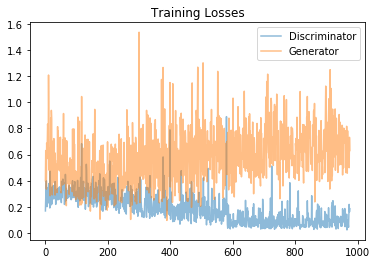

In [4]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [3]:
import pickle as pkl
import matplotlib.pyplot as plt
## helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [4]:
# Load samples from generator, taken while training
'''faces generated around 40 epoch, batch_size = 128'''
with open('train_samples_epoch_   44.pkl', 'rb') as f:
    samples = pkl.load(f)

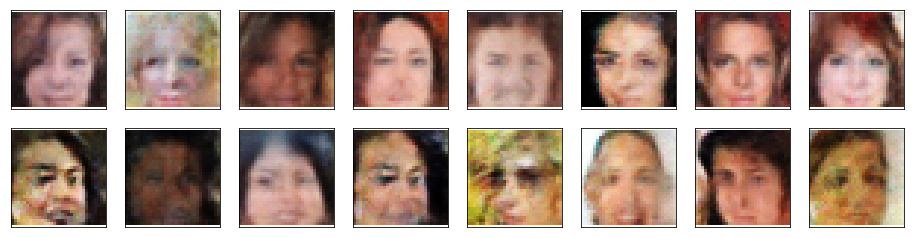

In [5]:
_ = view_samples(-1, samples)

In [10]:
# Load samples from generator, taken while training
'''faces generated around 20 epoch, batch_size = 64'''
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

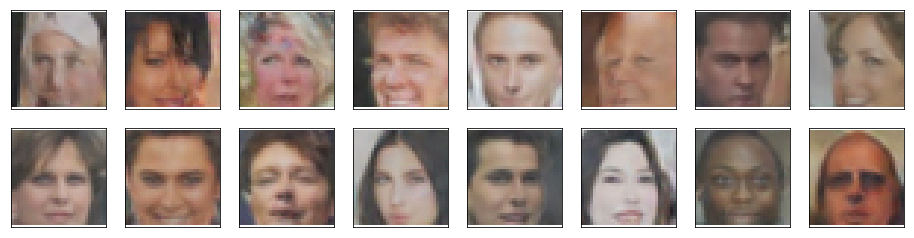

In [11]:
_ = view_samples(-1, samples)

In [14]:
# Load samples from generator, taken while training
'''faces generated around 35 epoch, batch_size = 128'''
with open('train_samples_epoch_   35.pkl', 'rb') as f:
    samples = pkl.load(f)

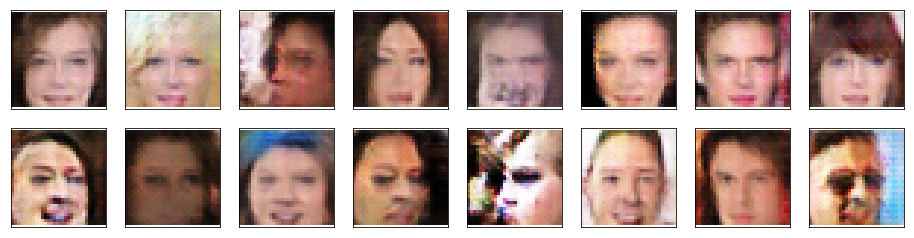

In [15]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
The generator loss should be gradually decreased. 
* I would considering delete human portrait with accessories like sunglasses, they cause problems like the model might thinks sunglasses is part of human face. In addition, remove or whitening all other backgrounds around the faces.
* Gather more datasets with variety and diversity of faces
* Apply different adaptive learning rate strategies. 
* Use image crop instead of resize with Pytorch.
* Use a different initialization for latent vector (e.g. Normal distribution instead of Uniform Dist)
* Change to different smooth label techniques, adding noise to the discriminator, etc. (Salimans et. al. 2016).
* Use different loss functions other than least square loss (e.g. Wasserstein GAN loss). 
* Create larger generator than discriminator.
* Train discriminator more than the generator.
* Considering use pre-trained discriminator on larger dataset. 
* Use different learning rate for discriminator and generator.
* Tuning the hyper-parameters associated with G and D.
* Apply dropout layers to mitigate overfitting.
* Apply embedding layers.
* Try to avoid using a even-sized kernel, which might cause aliasing errors. (e.g. use odd sized kernel, 3x3, 5x5). 
* Try to use attention techniques for DCGAN. 
* Finally, indeed, I would considering 300 epochs or more would provide me with better generated faces than 20 ~ 30 epochs.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

##### Question:
The behaviour of the losses, they seem not to decrease significantly in first 20 epochs, but the model could still produce human faces with acceptable resolutions within iterations. How could we judge whether a model is 'accurate' based on losses as numerical metrics? 

**Answer:** 
* https://towardsdatascience.com/understanding-and-optimizing-gans-going-back-to-first-principles-e5df8835ae18
* https://github.com/soumith/ganhacks/issues/29
* https://ai.stackexchange.com/questions/3488/understanding-gan-loss-function
